# Introduction

In this project I have compared 2 models for parallel execution of tasks - "Intent Classifier and Named Entity Recognition". In any chatbot, Intent Classifier assigns task labels to input texts and further functions in pipeline are applied specific to task labels. Named entities if recognised will help refine subtasks, because the computer will know if certain entities are mentioned by the user. The models I have used are -  

1.   DistilBert 
2.   Bidirectional GRU with CRF head

The models are trained on dataset specific to personal retail banking. So the scope of the chatbot built on top of these models should be as follows -

1.   Perform payment transactions 
2.   Give brief transactions history based on filters like 'transactions in January'
3.   Check balances in different types of accounts
4.   Answer queries related to products

NOTE: You can find a bit more explaination about 'Intent Classification and NER'  with examples in "Model planing" section.

NER tags to be identified are all nouns (name start/end tags and product name start/end tags), the neural networks will pick up similar syntactic relations for the tags and if they have weak semantic learners the models will fail. So, even if we have only 4 tags to predict, still it is a difficult task because of the nature of tags.



# Imports

In [ ]:

!pip install transformers
from transformers import DistilBertTokenizerFast , TFDistilBertModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Dense , Conv1D , Softmax , Reshape , GRU , Embedding , Bidirectional
from tensorflow_addons.text import crf_log_likelihood , viterbi_decode
import time


# Dataset


The dataset was generated based on examples in RASA github and some FAQs from retail banking websites. To illustrate, let's say we have below template of a "data point" - 


---


sentence - "Pay [ id ] with my [ product ] [ product ]"

labels - ['o' , 's-id' , 'o' , 'o' , 's-product' , 'e-product']

intent - 'transaction'


---


We can fill in [ id ] with anything like John , milk , groceries , etc and [ product ] with banking products like credit card or debit card.

Rasa repository - https://github.com/RasaHQ/financial-demo/blob/master/data/nlu/nlu.md


In [ ]:

with open('chatbot_data' , 'rb') as f:
    dataset = pickle.load(f)
dataset.iloc[np.random.randint(50 , 2000 , 15)]


,sentences,labels,intents
1155,"[how, much, money, amount, mayur, thakur, sent...","[o, o, o, o, s-id, e-id, o, o, o, o, o]",analyze_transactions
539,"[give, yash, patel, 589]","[o, s-id, e-id, o]",transactions_intent
1062,"[how, much, money, was, credited, to, my, acco...","[o, o, o, o, o, o, o, o, o]",analyze_transactions
968,"[please, send, 800, to, amit, yadav, using, si...","[o, o, o, o, s-id, e-id, o, s-product, e-product]",transactions_intent
1093,"[how, much, money, amount, vani, sent, me, today]","[o, o, o, o, s-id, o, o, o]",analyze_transactions
1554,"[how, much, money, amount, was, paid, to, yash...","[o, o, o, o, o, o, o, s-id, o, o, o]",analyze_transactions
1739,"[how, much, money, amount, was, sent, to, repa...","[o, o, o, o, o, o, o, s-id, o]",analyze_transactions
1019,"[pay, interest, due, using, platinum, card]","[o, o, o, o, s-product, e-product]",transactions_intent
286,"[change, this, name, from, priyanka, patel, to]","[o, o, o, o, s-id, e-id, o]",bank_related
73,"[add, divya, as, benefeciary]","[o, s-id, o, o]",bank_related



Count of out of context tags - 16641 



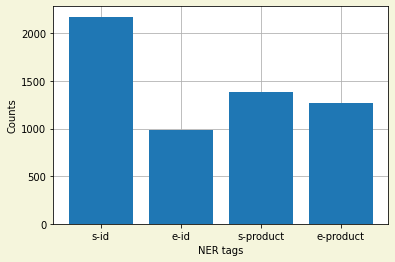

In [ ]:

eval_list = []
for i in dataset['labels']:
    eval_list += i

unique_labels = ['o' , 's-id' , 'e-id' , 's-product' , 'e-product']
counts = [] 
for i in unique_labels:
    counts.append(eval_list.count(i))

print('\nCount of out of context tags -' , counts[0] , '\n')

plt.figure(facecolor='beige')
plt.xlabel('NER tags')
plt.ylabel('Counts')
plt.bar( x=unique_labels[1:] , height=counts[1:] , zorder=2.5)
plt.grid()
plt.show()


Apart from imbalance due to label 'o' (out of context tags), the rest of the tags are moderately imbalanced. However, accuracy will shoot up if we are able to predict words which are not a noun. Thus, we will need to see the confusion matrix well.


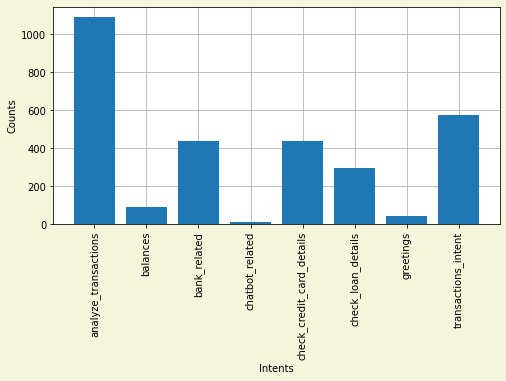

In [ ]:

counter = CountVectorizer()
counts = counter.fit_transform(dataset['intents']).toarray().sum(axis=0)

plt.figure(facecolor='beige' , figsize=(8,4))
plt.xlabel('Intents')
plt.ylabel('Counts')
plt.bar( x=counter.get_feature_names() , height=counts , zorder=2.5)
plt.grid()
plt.xticks(rotation = 'vertical')
plt.show()


 
We see that intents are even more imbalanced, ideally in such cases we would upsample or downsample data points, but because we generated data by replicating templates, upsampling may not be a good idea, still with such complex models we can expect models to perform just fine.


# Tokenization 

In [ ]:

data = list(dataset['sentences'])
labels = list(dataset['labels'])
intents = list(dataset['intents'])

train_text_og , test_text_og , train_labels , test_labels , train_intents , test_intents = train_test_split( data , labels , intents , stratify = intents)


**Tokenization** is to decontstruct sentence into words / subwords / characters, later to be converted to vector (numeric) representation (eg: 'walking' has subwords 'walk' , 'ing'). In this project we use pretrained **Wordpiece Tokenizer** in Huggingface library. Wordpiece tokenizer merges frequently occuring character tokens given that the probability of merged tokens is higher than the probability of indivisual token occurrence. You can see example of tokenized sentences below. 

Note: Vocabulary is relative to the documents the tokenizer has trained on


In [ ]:

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_text = tokenizer(train_text_og, is_pretokenized=True, return_offsets_mapping=True, padding='max_length', truncation=True, max_length=50)
test_text = tokenizer(test_text_og, is_pretokenized=True, return_offsets_mapping=True, padding='max_length', truncation=True, max_length=50)

# Below is what the hugging face pretrained tokenizer does out of vocabulary words
print('\n' , '='*50 , ' original ' , '='*50 , '\n')
print(train_text[54])
print('\n' , '='*44 , ' pretrained vocab ids ' , '='*44 , '\n')
print(train_text.input_ids[54])
print('\n' , '='*45 , ' deconstructed words ' , '='*45 , '\n')
print(tokenizer.convert_ids_to_tokens(train_text.input_ids[54]))
print('\n' , '='*47 , ' offset mapping ' , '='*47 , '\n')
print(train_text.offset_mapping[54])
print('\n')


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_fast.py:353: FutureWarning: `is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.
  FutureWarning,



 ==================================================  original  ================================================== 

Encoding(num_tokens=50, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

 ============================================  pretrained vocab ids  ============================================ 

[101, 2129, 2172, 2769, 3815, 2001, 2741, 2000, 15544, 3148, 12277, 3207, 1999, 2627, 1020, 2420, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 =============================================  deconstructed words  ============================================= 

['[CLS]', 'how', 'much', 'money', 'amount', 'was', 'sent', 'to', 'ri', '##ya', 'shin', '##de', 'in', 'past', '6', 'days', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

# Encode NER tags


We are simply encoding NER tags to be picked up by loss function "sparse categorical cross entropy" in tensorflow library. 

In [ ]:

def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    t = 0
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * 5
        arr_offset = np.array(doc_offset)
        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

unique_labels = ['o' , 's-id' , 'e-id' , 's-product' , 'e-product'] 
tag2id = {'o' : 0 , 's-id' : 1 , 'e-id' : 2 , 's-product' : 3 , 'e-product' : 4}

encoded_train_labels = np.array(encode_tags(train_labels, train_text))
encoded_test_labels = np.array(encode_tags(test_labels, test_text))


In [ ]:

train_input_ids = np.array(train_text.input_ids)
train_attention_mask = np.array(train_text.attention_mask)

test_input_ids = np.array(test_text.input_ids)
test_attention_mask = np.array(test_text.attention_mask)

bag_of_words = CountVectorizer() 
train_intents = bag_of_words.fit_transform(train_intents).toarray()
test_intents = bag_of_words.fit_transform(test_intents).toarray()


In [ ]:

print(train_input_ids.shape)
print(train_attention_mask.shape)
print(encoded_train_labels.shape)
print(train_intents.shape)

print(test_input_ids.shape)
print(test_attention_mask.shape)
print(encoded_test_labels.shape)
print(test_intents.shape)


(2239, 50)
(2239, 50)
(2239, 50)
(2239, 8)
(747, 50)
(747, 50)
(747, 50)
(747, 8)


# Model Planning

A very simple chatbot which will only fetch data from a prestored questions answers table, will output answer to most similar question (from table) w.r.t. the user question. The similarity could be found by using aggregated word vectors in questions. You can find the below link to see how it is done -

https://in.springboard.com/blog/nlp-project-automated-question-answering-model/

In our project apart from just fetching answers, we also need the chatbot to perform tasks. So, is it not possible with the simple model? It is definitely possible, we simply replace the answers in prestored tables with functions to perform. So, what is the catch?



A question could be asked many different ways, thus we may need to store different types of question for each answer in table. Similarities will be checked for each of teses questions. Moreover, in practice a chatbot is only economical if it replaces a wide range of queries. Also, the user experience is important which means we can't compromise on accuracy. All of these requirements make the table of question and answers / functions really huge. Comparing similarity scores for each question will be time consuming. 


**Intent classification**

If questions in tables are classified by "intent" labels, we now will have binned questions in respective intents. Thus, checking similarity scores or performing other techniques to continue pipeline is now on a smaller chunk of the whole table. Some strategy deciding intents - 

[1] Leveraging the efficiency of a model to classify intents : 

Let's say we got below 2 inputs - 

- what is my account balance ?
- what is my credit card balance ?

We can assign both of the above under one intent - "balance_enquiry" or we could assign them to two different intents - "account_enquiry" & "card_enquiry". If models are suited to handle increased complexity, they should before hand classify them into seperate intents. Also, notice that "account_enquiry" may have other questions in the set like "what is my account type?", but, the 2 queries in "account_enquiry" intent is easily seperable (using vector similarities) than 2 queries in "balance_enquiry"

[2] Eliminate unwanted steps :

Let's say we got below 2 inputs -

- Can i pay John using chatbot?
- pay John 1000

You can choose to put the 1st question under "FAQ" intent and 2nd one under "transaction" intent, or alternatively we can eliminate a step and train model to put them both under "transaction" intent (to initiate transaction with missing entity = money amount). Notice that, since the words in sentences are similar in this case it will also take a load off the classifier.


**How useful are NER tags?**

A simple example is one given just above, we can check given an intent that some prerequisite tags are present to satisfy further functions in pipeline. If a word is identified as an entity, we can use the word vector to match similarity. Example - if user inputs "what were my grocery spendings" and we had recorded transactional tags for "milk", "bread", etc, the model might identify "grocery" as a tag and then match it with tags like "milk" & "bread" tags.




**Parallel training**

Both models give multiple outputs using the same network, training them parallely on loss from NER tags and loss from intents increases the scope of loss correction. It could be thought of one loss teacher forcing the other, synergically giving better results. This is also proven in the paper below - 

https://arxiv.org/pdf/1902.10909.pdf



# Distilbert Model

## Model structure

In [ ]:

transformer = TFDistilBertModel.from_pretrained('distilbert-base-uncased' , trainable = True)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:

tf.keras.backend.clear_session()

num_classes_ner = 6
max_length = 50

input_ids = tf.keras.Input( shape = max_length , dtype = 'int32' , name = 'input_ids' )
attention_mask = tf.keras.Input( shape = max_length , dtype = 'int32' , name = 'attention_mask' )

x = transformer.distilbert( [input_ids , attention_mask] )[0]

cls = tf.slice( x , [0,0,0] , [-1,1,-1] , name = 'slice1' )
cls = Reshape((768,))(cls)
cls = Dense( 8 , activation='softmax' , name = 'cls_output' )(cls)

sentence = tf.slice( x , [0,1,0] , [-1,(max_length-1),-1] , name = 'slice2' )
sentence = Conv1D( num_classes_ner , 1 , activation = 'relu' , name = 'Conv1D' )(sentence)
sentence = Softmax( axis=-1 , name = 'sentence_output' )(sentence)

bert_model = tf.keras.Model( inputs = [input_ids , attention_mask] , outputs = [cls , sentence , x])
bert_model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay ((None, 50, 768),)   66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf_op_layer_slice1 (TensorFlowO [(None, 1, 768)]     0           distilbert[0][0]      

## Custom training

In [ ]:

def shuffle( input_ids , attention_mask , intents , encoded_labels ):

    index = np.arange(len(input_ids))
    np.random.shuffle(index)
    input_ids = input_ids[index]
    attention_mask = attention_mask[index]
    intents = intents[index]
    encoded_labels = encoded_labels[index]

    return input_ids , attention_mask , intents , encoded_labels


In [ ]:

# Train parameters

epochs = 6
train_batch_size = 20

cce = tf.keras.losses.CategoricalCrossentropy()
scce = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

ca_train = tf.keras.metrics.CategoricalAccuracy()
sca_train = tf.keras.metrics.SparseCategoricalAccuracy()

ca_test = tf.keras.metrics.CategoricalAccuracy()
sca_test = tf.keras.metrics.SparseCategoricalAccuracy()


In [ ]:

@tf.function

def train_batch( input_ids , attention_mask , intents , encoded_labels , batch_size ):

    bert_model.trainable = True

    with tf.GradientTape() as tape:

        cls , sentence , vectors = bert_model([ input_ids , attention_mask ])
        
        loss = cce( intents , cls )

        focus = tf.concat( ( attention_mask[:,2:] , np.arange(batch_size).reshape(-1,1) ) , axis=1 )

        loss += scce( encoded_labels[:,1:] , sentence , sample_weight = focus )

        variables = bert_model.trainable_variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

    ca_train.update_state( intents , cls )

    sca_train.update_state( encoded_labels[:,1:] , sentence , sample_weight = focus )

    return loss , ca_train.result() , sca_train.result()


In [ ]:

@tf.function

def evaluate( input_ids , attention_mask , intents , encoded_labels ):

    bert_model.trainable = False

    cls , sentence , vectors = bert_model([ input_ids , attention_mask ])
        
    loss = cce( intents , cls )

    focus = tf.concat( ( attention_mask[:,2:] , np.arange(len(input_ids)).reshape(-1,1) ) , axis=1 )

    loss += scce( encoded_labels[:,1:] , sentence , sample_weight = focus )

    ca_test.update_state( intents , cls )

    sca_test.update_state( encoded_labels[:,1:] , sentence , sample_weight = focus )

    return loss , ca_test.result() , sca_test.result()


In [ ]:

for i in range(epochs):

    train_input_ids , train_attention_mask , train_intents , encoded_train_labels = \
    shuffle( train_input_ids , train_attention_mask , train_intents , encoded_train_labels )

    ca_train.reset_states()
    sca_train.reset_states()
    ca_test.reset_states()
    sca_test.reset_states()

    for j in range(len(train_input_ids) // train_batch_size):

        a = j * train_batch_size
        b = (j+1) * train_batch_size
        train_loss , train_cls_accuracy , train_ner_accuracy = train_batch( train_input_ids[a:b] , train_attention_mask[a:b] , 
                                                                            train_intents[a:b], encoded_train_labels[a:b] ,
                                                                            train_batch_size)
        
    test_loss , test_cls_accuracy , test_ner_accuracy = evaluate( test_input_ids , test_attention_mask , test_intents , encoded_test_labels )

    print('@ epoch %2d , @ batch %2d\n train_loss = %.5f | train_cls_accuracy %.5f | train_ner_accuracy %.5f\n test_loss = %.5f | test_cls_accuracy %.5f | test_ner_accuracy %.5f'\
          %(i+1 , j+1 ,train_loss.numpy() , train_cls_accuracy.numpy() , train_ner_accuracy.numpy() , 
          test_loss.numpy() , test_cls_accuracy.numpy() , test_ner_accuracy.numpy()))

    with open('save.csv','a') as f:
        f.write( str(( i+1 ,train_loss.numpy() , train_cls_accuracy.numpy() , train_ner_accuracy.numpy() , 
                 test_loss.numpy() , test_cls_accuracy.numpy() , test_ner_accuracy.numpy() ))[1:-1] +'\n' )


@ epoch  1 , @ batch 111
 train_loss = 0.03870 | train_cls_accuracy 0.94550 | train_ner_accuracy 0.90144
 test_loss = 0.04455 | test_cls_accuracy 0.99866 | test_ner_accuracy 0.99792
@ epoch  2 , @ batch 111
 train_loss = 0.01273 | train_cls_accuracy 0.99730 | train_ner_accuracy 0.96307
 test_loss = 0.01527 | test_cls_accuracy 1.00000 | test_ner_accuracy 0.99966
@ epoch  3 , @ batch 111
 train_loss = 0.00050 | train_cls_accuracy 1.00000 | train_ner_accuracy 0.99934
 test_loss = 0.00181 | test_cls_accuracy 1.00000 | test_ner_accuracy 0.99997
@ epoch  4 , @ batch 111
 train_loss = 0.00026 | train_cls_accuracy 1.00000 | train_ner_accuracy 0.99988
 test_loss = 0.00151 | test_cls_accuracy 1.00000 | test_ner_accuracy 0.99998
@ epoch  5 , @ batch 111
 train_loss = 0.00366 | train_cls_accuracy 1.00000 | train_ner_accuracy 0.99988
 test_loss = 0.00124 | test_cls_accuracy 1.00000 | test_ner_accuracy 0.99998
@ epoch  6 , @ batch 111
 train_loss = 0.00011 | train_cls_accuracy 1.00000 | train_ner_ac

In [ ]:

bert_model.save('/content/drive/My Drive/AAI/models/bert_model')
bert_model.save('/content/drive/My Drive/AAI/models/bert_model.h5')


INFO:tensorflow:Assets written to: /content/drive/My Drive/AAI/models/bert_model/assets


## Results



NOTE: You can find code by code explaination for this section in inference notebook

In [ ]:

unique_intents =  np.array( bag_of_words.get_feature_names() )
id2tag = { 0 : 'o' , 1 : 's-id', 2 : 'e-id', 3 : 's-product', 4 : 'e-product' , 5 : 'na' }

def bert_model_out( text ):

    intent_predictions = []

    ner_predictions = []

    word_vectors = []


    text = [text.split(' ')]
    encoding = tokenizer(text , is_pretokenized = True , return_offsets_mapping=True , padding='max_length' , truncation=True , max_length=50)

    input_ids = np.array(encoding.input_ids)
    attention_mask = np.array(encoding.attention_mask)
    offset_mapping = encoding.offset_mapping

    cls , sentence , vectors = bert_model([input_ids , attention_mask])

    sentence_vector = vectors[0,0,:]

    intent_predictions = unique_intents[tf.math.argmax(cls , axis = 1).numpy()][0] 

    # Span of words is offset by the tokenizer i.e tokenization( rahul ) will be something like r , ##ah , ##ul 
    # offset_mapping is values representing this change - for rahul the values will be - (0,1) , (1,3) , (3,5) 
    # below code is to detect span of such tokens in a sentence
    # example sentence - pay rahul 1000 dollars
    # example tokenization - [ pay , r , ##ah , ##ul , 1000 , dollars]
    # example span of word disintegration - from index 1 upto 3 , i.e for slice = tokenized_sentence[1:4]

    te1 = np.array([i for i,j in offset_mapping[0]]) > 0
    te2 = np.roll( te1 , 1 )
    starts = te1 & ~te2
    ends = ~te1 & te2
    starts = np.nonzero(starts)[0]
    ends = np.nonzero(ends)[0]
    start_end = dict(zip(starts,ends))

    # Reference for detecting span of nonzero values
    # https://stackoverflow.com/questions/17150974/find-span-where-condition-is-true-using-numpy

    k = 1
    for i in text[0]:

        if k in start_end.keys():

            probs = sentence[0 , k-1 , : ]

            ner = tf.math.argmax(probs).numpy()
            ner = id2tag[ner]
            ner_predictions.append(ner)

            word_vector = tf.reduce_mean(vectors[0 , k:start_end[k] , : ] , axis = 0)               
            word_vectors.append(word_vector)

            k = start_end[k]
            

        else:

            probs = sentence[0 , k-1 , : ]
            
            ner = tf.math.argmax(probs).numpy()
            ner = id2tag[ner]
            ner_predictions.append(ner)

            word_vector = vectors[0 , k , :]
            word_vectors.append(word_vector)

            k += 1
            
    return intent_predictions , ner_predictions , word_vectors , sentence_vector


In [ ]:

intent_predictions , ner_predictions , word_vectors , sentence_vector = bert_model_out('pay ravikanth using my gold card')

print(intent_predictions ,'\n')
print(ner_predictions ,'\n') 
print([i.shape for i in word_vectors] ,'\n')
print(sentence_vector.shape,'\n')


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_fast.py:353: FutureWarning: `is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.
  FutureWarning,


transactions_intent 

['o', 's-id', 'na', 'o', 'o', 's-product'] 

[TensorShape([768]), TensorShape([768]), TensorShape([768]), TensorShape([768]), TensorShape([768]), TensorShape([768])] 

(768,) 



In [ ]:

# NER tags in dataset
id2tag = { 0 : 'o' , 1 : 's-id', 2 : 'e-id', 3 : 's-product', 4 : 'e-product' , 5 : 'na' }

# Intents in dataset
bag_of_words.get_feature_names()


['analyze_transactions',
 'balances',
 'bank_related',
 'chatbot_related',
 'check_credit_card_details',
 'check_loan_details',
 'greetings',
 'transactions_intent']

## Performance metrics

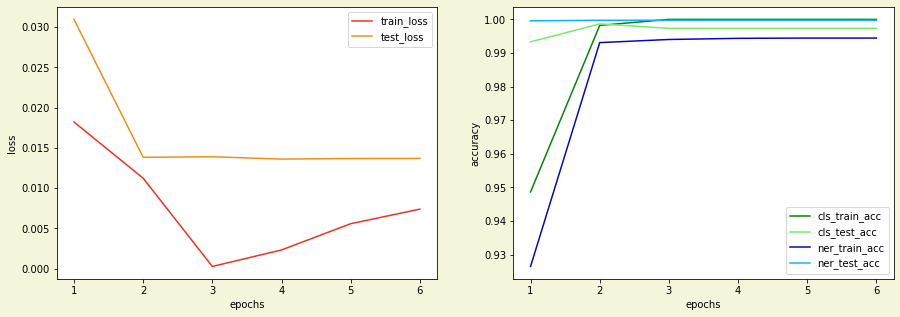

In [ ]:

performance_data = pd.read_csv('save.csv')
performance_data = performance_data[:6]
plt.figure(facecolor='beige' , figsize=(15,5))

plt.subplot(121)
plt.xlabel('epochs') ; plt.ylabel('loss')
plt.plot(performance_data['epoch'] , performance_data['train_loss'] , color='#EF3220' , label='train_loss' )
plt.plot(performance_data['epoch'] , performance_data['test_loss'] , color='#F38E16' , label='test_loss' )
plt.legend()

plt.subplot(122)
plt.xlabel('epochs') ; plt.ylabel('accuracy')
plt.plot(performance_data['epoch'] , performance_data['cls_train_acc'] , color='#048402' , label='cls_train_acc' )
plt.plot(performance_data['epoch'] , performance_data['cls_test_acc'] , color='#75ED65' , label='cls_test_acc' )
plt.plot(performance_data['epoch'] , performance_data['ner_train_acc'] , color='#0507BE' , label='ner_train_acc' )
plt.plot(performance_data['epoch'] , performance_data['ner_test_acc'] , color='#07B4FF' , label='ner_test_acc' )
plt.legend()

plt.show()


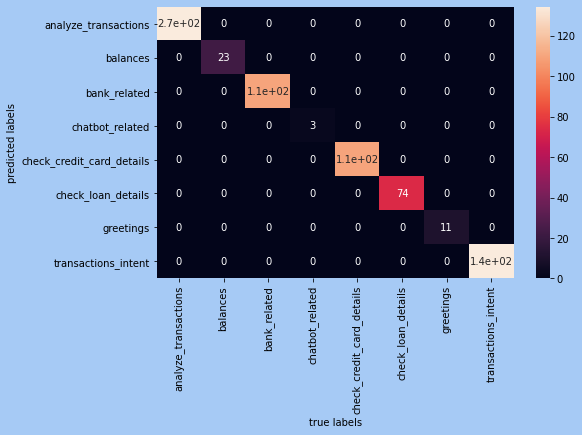

In [ ]:

cls , sentence , vectors = bert_model([test_input_ids , test_attention_mask])
pred_intents = tf.math.argmax(cls , axis = 1).numpy()
intent_actual = tf.math.argmax(test_intents , axis = 1).numpy()

bert_mat_intents = confusion_matrix(intent_actual, pred_intents , labels=[0,1,2,3,4,5,6,7])

plt.figure(facecolor='#A6CAF5' , figsize=(8,5))
ax = sns.heatmap(bert_mat_intents ,robust=True , annot=True , 
                 xticklabels = bag_of_words.get_feature_names() , 
                 yticklabels = bag_of_words.get_feature_names())
ax.set(xlabel='true labels', ylabel='predicted labels')
plt.show()


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_fast.py:353: FutureWarning: `is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.
  FutureWarning,


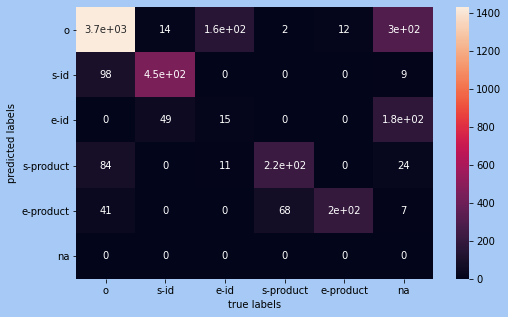

In [ ]:

pred_ner = []
ner_actual = []

for i,j in zip(test_text_og , test_labels):

    pred_ner += bert_model_out(' '.join(i))[1]
    ner_actual += j 

bert_ner_intents = confusion_matrix(ner_actual , pred_ner , labels = list(id2tag.values()))

plt.figure(facecolor='#A6CAF5' , figsize=(8,5))
ax = sns.heatmap(bert_ner_intents ,robust=True , annot=True ,
                 xticklabels = list(id2tag.values()) , 
                 yticklabels = list(id2tag.values()))
ax.set(xlabel='true labels', ylabel='predicted labels')
plt.show()


In [ ]:

start = time.time()
count = 0
elapsed = 0

while elapsed < 1:
    count += 1 
    a,b,c,d = bert_model_out('pay ravikanth using my credit card')
    elapsed = time.time() - start

print(count)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_fast.py:353: FutureWarning: `is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.
  FutureWarning,


17



# GRU + CRF Model


## Model structure

In [ ]:

num_classes_ner = 6
max_length = 50
vocab_size = tokenizer.vocab_size

input_ids = tf.keras.Input( shape = max_length , dtype = 'int32' , name = 'input_ids' )

emb_inp = Embedding( input_dim = vocab_size , output_dim = 300 , 
                     input_length = max_length, trainable = True , name = 'Word_Embedding_11' )(input_ids)

x = Bidirectional(GRU( 150 , return_sequences = True , name = 'encoder' ))(emb_inp)

cls = Reshape((-1,))(x)
cls = Dense( 150 , activation='relu' , name = 'cls_dense1' )(cls)
cls = Dense( 8 , activation='softmax' , name = 'cls_output' )(cls)

sentence = tf.slice( x , [0,1,0] , [-1,(max_length-1),-1] , name = 'slice2' )
sentence = Conv1D( num_classes_ner , 1 , activation = 'relu' , name = 'Conv1D' )(sentence)

gru_model = tf.keras.Model( inputs = input_ids , outputs = [cls , sentence , x])

gru_model.summary()


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
Word_Embedding_11 (Embedding)   (None, 50, 300)      9156600     input_ids[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 300)      406800      Word_Embedding_11[0][0]          
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 15000)        0           bidirectional_1[0][0]            
_______________________________________________________________________________________

## Custom training

In [ ]:

class sequence_accuracy():

    def __init__(self):
        self.accuracy = 0
        self.d = 1

    def update_states( self , seq_prediction , seq_actual ):
        te = np.sum(np.array(seq_prediction) == np.array(seq_actual)) / len(seq_prediction)
        self.accuracy = (self.accuracy + te) / self.d
        self.d = 2

    def reset_states(self):
        self.accuracy = 0
        self.d = 1


In [ ]:

transition_params = tf.keras.initializers.GlorotNormal()((6,6))

cce = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5)

ca_train = tf.keras.metrics.CategoricalAccuracy()
ca_test = tf.keras.metrics.CategoricalAccuracy()

sa_train = sequence_accuracy()
sa_test = sequence_accuracy()


In [ ]:

def train_batch( input_ids , attention_mask , intents , encoded_labels ):

    global transition_params 

    gru_model.trainable = True

    with tf.GradientTape() as tape:

        cls , sentence , vectors = gru_model(input_ids)
        
        loss = cce( intents , cls )

        focus = tf.reduce_sum(attention_mask , axis = 1) - 2 

        l , transition_params = crf_log_likelihood( sentence , encoded_labels[:,1:] , focus , transition_params )

        loss += tf.reduce_mean( -l )

        variables = gru_model.trainable_variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables)) 

    ca_train.update_state( intents , cls )

    for i,j,k in zip(sentence.numpy() , encoded_labels[:,1:] , focus):
            
        pred = viterbi_decode( i[:k] , transition_params )[0]
        sa_train.update_states( pred , j[:k] )

    return loss.numpy() , ca_train.result().numpy() , sa_train.accuracy , transition_params

# Refernce
# https://github.com/tensorflow/addons/issues/1769
# https://www.tensorflow.org/addons/api_docs/python/tfa/text/crf_log_likelihood


In [ ]:

def evaluate(input_ids , attention_mask , intents , encoded_labels):

    global transition_params

    gru_model.trainable = False
    
    cls , sentence , vectors = gru_model(input_ids)

    loss = cce( intents , cls )

    focus = tf.reduce_sum(attention_mask , axis = 1) - 2 

    loss += tf.reduce_mean( -crf_log_likelihood( sentence , encoded_labels[:,1:] , focus )[0] )

    ca_test.update_state( intents , cls )

    for i,j,k in zip(sentence.numpy() , encoded_labels[:,1:] , focus):

        pred = viterbi_decode( i[:k] , transition_params )[0]
        sa_test.update_states( pred , j[:k] )

    return loss.numpy() , ca_test.result().numpy() , sa_test.accuracy 


In [ ]:

epochs = 15
train_batch_size = 20

for i in range(epochs):

    train_input_ids , train_attention_mask , train_intents , encoded_train_labels = \
    shuffle( train_input_ids , train_attention_mask , train_intents , encoded_train_labels )

    ca_train.reset_states()
    sa_train.reset_states()
    ca_test.reset_states()
    sa_test.reset_states()

    for j in range(len(train_input_ids) // train_batch_size):

        a = j * train_batch_size
        b = (j+1) * train_batch_size
        train_loss , train_cls_accuracy , train_ner_accuracy , transition_params = train_batch( train_input_ids[a:b] , train_attention_mask[a:b] , 
                                                                                               train_intents[a:b], encoded_train_labels[a:b] )
        
    test_loss , test_cls_accuracy , test_ner_accuracy = evaluate( test_input_ids , test_attention_mask , test_intents , encoded_test_labels )

    print('@ epoch %2d , @ batch %2d\n train_loss = %.5f | train_cls_accuracy %.5f | train_ner_accuracy %.5f\n test_loss = %.5f | test_cls_accuracy %.5f | test_ner_accuracy %.5f'\
          %(i+1 , j+1 ,train_loss , train_cls_accuracy , train_ner_accuracy , test_loss , test_cls_accuracy , test_ner_accuracy))

    with open('save.csv','a') as f:
        f.write( str(( i+1 ,train_loss , train_cls_accuracy , train_ner_accuracy , test_loss , test_cls_accuracy , test_ner_accuracy))[1:-1] +'\n' )
        


@ epoch  1 , @ batch 111
 train_loss = 14.44696 | train_cls_accuracy 0.37342 | train_ner_accuracy 0.71439
 test_loss = 14.56220 | test_cls_accuracy 0.39759 | test_ner_accuracy 0.71043
@ epoch  2 , @ batch 111
 train_loss = 11.14654 | train_cls_accuracy 0.54595 | train_ner_accuracy 0.69753
 test_loss = 10.67227 | test_cls_accuracy 0.70683 | test_ner_accuracy 0.68266
@ epoch  3 , @ batch 111
 train_loss = 7.42399 | train_cls_accuracy 0.73784 | train_ner_accuracy 0.78085
 test_loss = 8.97972 | test_cls_accuracy 0.80857 | test_ner_accuracy 0.68288
@ epoch  4 , @ batch 111
 train_loss = 6.56743 | train_cls_accuracy 0.80495 | train_ner_accuracy 0.79667
 test_loss = 6.93695 | test_cls_accuracy 0.85141 | test_ner_accuracy 0.80746
@ epoch  5 , @ batch 111
 train_loss = 4.72424 | train_cls_accuracy 0.85045 | train_ner_accuracy 0.76310
 test_loss = 5.20447 | test_cls_accuracy 0.87015 | test_ner_accuracy 0.83490
@ epoch  6 , @ batch 111
 train_loss = 3.23301 | train_cls_accuracy 0.87162 | train_ne

In [ ]:

gru_model.save('/content/drive/My Drive/AAI/models/gru_model')
gru_model.save('/content/drive/My Drive/AAI/models/gru_model.h5')


INFO:tensorflow:Assets written to: /content/drive/My Drive/AAI/models/gru_model/assets


In [ ]:

with open('/content/drive/My Drive/AAI/models/crf_transition_params' , 'wb') as f:
    pickle.dump(transition_params , f)
    

## Results

NOTE: You can find code by code explaination for this section in inference notebook

In [ ]:

unique_intents =  np.array( bag_of_words.get_feature_names() )
id2tag = { 0 : 'o' , 1 : 's-id', 2 : 'e-id', 3 : 's-product', 4 : 'e-product' , 5 : 'na' }

def gru_model_out( text ):

    intent_predictions = []

    ner_predictions = []

    word_vectors = []


    text = [text.split(' ')]
    encoding = tokenizer(text , is_pretokenized = True , return_offsets_mapping=True , padding='max_length' , truncation=True , max_length=50)

    input_ids = np.array(encoding.input_ids)
    attention_mask = np.array(encoding.attention_mask)
    offset_mapping = encoding.offset_mapping

    cls , sentence , vectors = gru_model(input_ids)
    sentence_vector = vectors[0,0,:]

    intent_predictions = unique_intents[tf.math.argmax(cls , axis = 1).numpy()][0] 

    target_sentence = viterbi_decode( sentence[0] , transition_params )[0]

    te1 = np.array([i for i,j in offset_mapping[0]]) > 0
    te2 = np.roll( te1 , 1 )
    starts = te1 & ~te2
    ends = ~te1 & te2
    starts = np.nonzero(starts)[0]
    ends = np.nonzero(ends)[0]
    start_end = dict(zip(starts,ends))

    k = 1
    for i in text[0]:

        if k in start_end.keys():

            ner = target_sentence[ k-1 ]
            ner = id2tag[ner]
            ner_predictions.append(ner)

            word_vector = tf.reduce_mean(vectors[0 , k:start_end[k] , : ] , axis = 0)               
            word_vectors.append(word_vector)

            k = start_end[k]
            

        else:

            ner = target_sentence[ k-1 ]
            ner = id2tag[ner]
            ner_predictions.append(ner)

            word_vector = vectors[0 , k , :]
            word_vectors.append(word_vector)

            k += 1

    return intent_predictions , ner_predictions , word_vectors , sentence_vector


In [ ]:

intent_predictions , ner_predictions , word_vectors , sentence_vector = gru_model_out('pay ravikanth using my credit card')

print(intent_predictions ,'\n')
print(ner_predictions ,'\n') 
print([i.shape for i in word_vectors] ,'\n')
print(sentence_vector.shape,'\n')


transactions_intent 

['o', 'o', 'o', 'o', 'o', 's-product'] 

[TensorShape([300]), TensorShape([300]), TensorShape([300]), TensorShape([300]), TensorShape([300]), TensorShape([300])] 

(300,) 



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_fast.py:353: FutureWarning: `is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.
  FutureWarning,


## Performance metrics

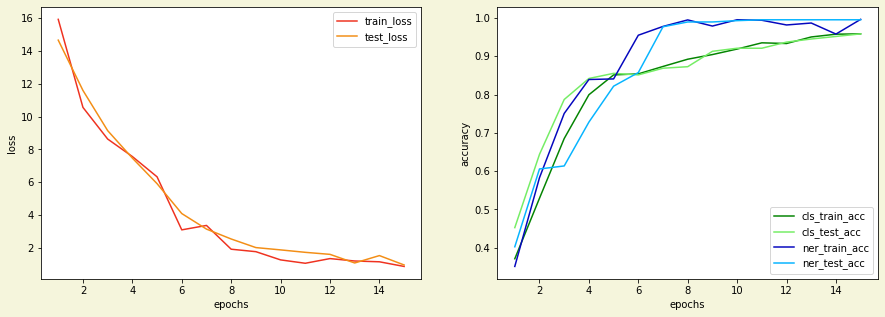

In [ ]:

performance_data = pd.read_csv('save.csv')
performance_data = performance_data[6:]
plt.figure(facecolor='beige' , figsize=(15,5))

plt.subplot(121)
plt.xlabel('epochs') ; plt.ylabel('loss')
plt.plot(performance_data['epoch'] , performance_data['train_loss'] , color='#EF3220' , label='train_loss' )
plt.plot(performance_data['epoch'] , performance_data['test_loss'] , color='#F38E16' , label='test_loss' )
plt.legend()

plt.subplot(122)
plt.xlabel('epochs') ; plt.ylabel('accuracy')
plt.plot(performance_data['epoch'] , performance_data['cls_train_acc'] , color='#048402' , label='cls_train_acc' )
plt.plot(performance_data['epoch'] , performance_data['cls_test_acc'] , color='#75ED65' , label='cls_test_acc' )
plt.plot(performance_data['epoch'] , performance_data['ner_train_acc'] , color='#0507BE' , label='ner_train_acc' )
plt.plot(performance_data['epoch'] , performance_data['ner_test_acc'] , color='#07B4FF' , label='ner_test_acc' )
plt.legend()

plt.show()


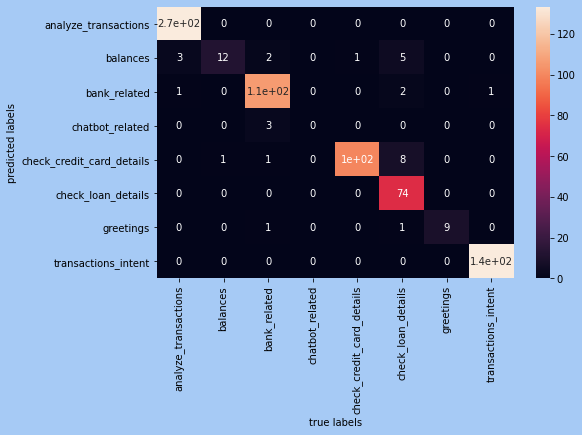

In [ ]:

cls , sentence , vectors = gru_model(test_input_ids)
pred_intents = tf.math.argmax(cls , axis = 1).numpy()
intent_actual = tf.math.argmax(test_intents , axis = 1).numpy()

gru_mat_intents = confusion_matrix(intent_actual, pred_intents , labels=[0,1,2,3,4,5,6,7] )

plt.figure(facecolor='#A6CAF5' , figsize=(8,5))
ax = sns.heatmap(gru_mat_intents ,robust=True , annot=True , 
                 xticklabels = bag_of_words.get_feature_names() , 
                 yticklabels = bag_of_words.get_feature_names())
ax.set(xlabel='true labels', ylabel='predicted labels')
plt.show()


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_fast.py:353: FutureWarning: `is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.
  FutureWarning,


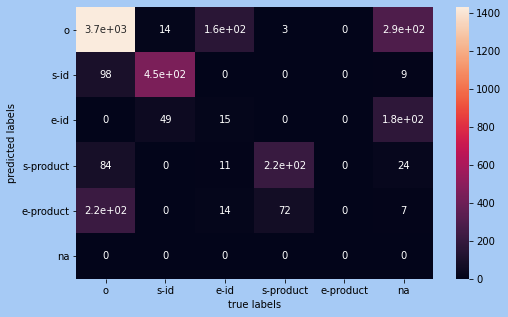

In [ ]:

pred_ner = []
ner_actual = []

for i,j in zip(test_text_og , test_labels):

    pred_ner += gru_model_out(' '.join(i))[1]
    ner_actual += j 

gru_ner_intents = confusion_matrix(ner_actual, pred_ner , labels = list(id2tag.values()))

plt.figure(facecolor='#A6CAF5' , figsize=(8,5))
ax = sns.heatmap(gru_ner_intents ,robust=True , annot=True , 
                 xticklabels = list(id2tag.values()) , 
                 yticklabels = list(id2tag.values()))
ax.set(xlabel='true labels', ylabel='predicted labels')
plt.show()


In [ ]:

start = time.time()
count = 0
elapsed = 0

while elapsed < 1:
    count += 1 
    a,b,c,d = gru_model_out('pay ravikanth using my credit card')
    elapsed = time.time() - start

print(count)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_fast.py:353: FutureWarning: `is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.
  FutureWarning,


19
